# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [58]:
plt.rcParams["figure.figsize"] = (10, 10)

### Import and explore the data. Clean the data for outliers and missing values. 

In [3]:
boston = load_boston()

In [17]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [10]:
df = pd.DataFrame(boston.data, columns = boston.feature_names)

In [11]:
df['MEDV'] = boston.target

In [15]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [18]:
X = boston.data
y = boston.target

In [36]:
q1 = df.quantile(0.25)

In [37]:
q3 = df.quantile(0.75)

In [38]:
iqr = q3 - q1

In [45]:
len(df[(df > (q1 - 1.5 * iqr)) |(df < (q3 + 1.5 * iqr))])

506

In [46]:
len(df)
# the length of the df without outliers is the same as the original df, so there are no outliers 

506

### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

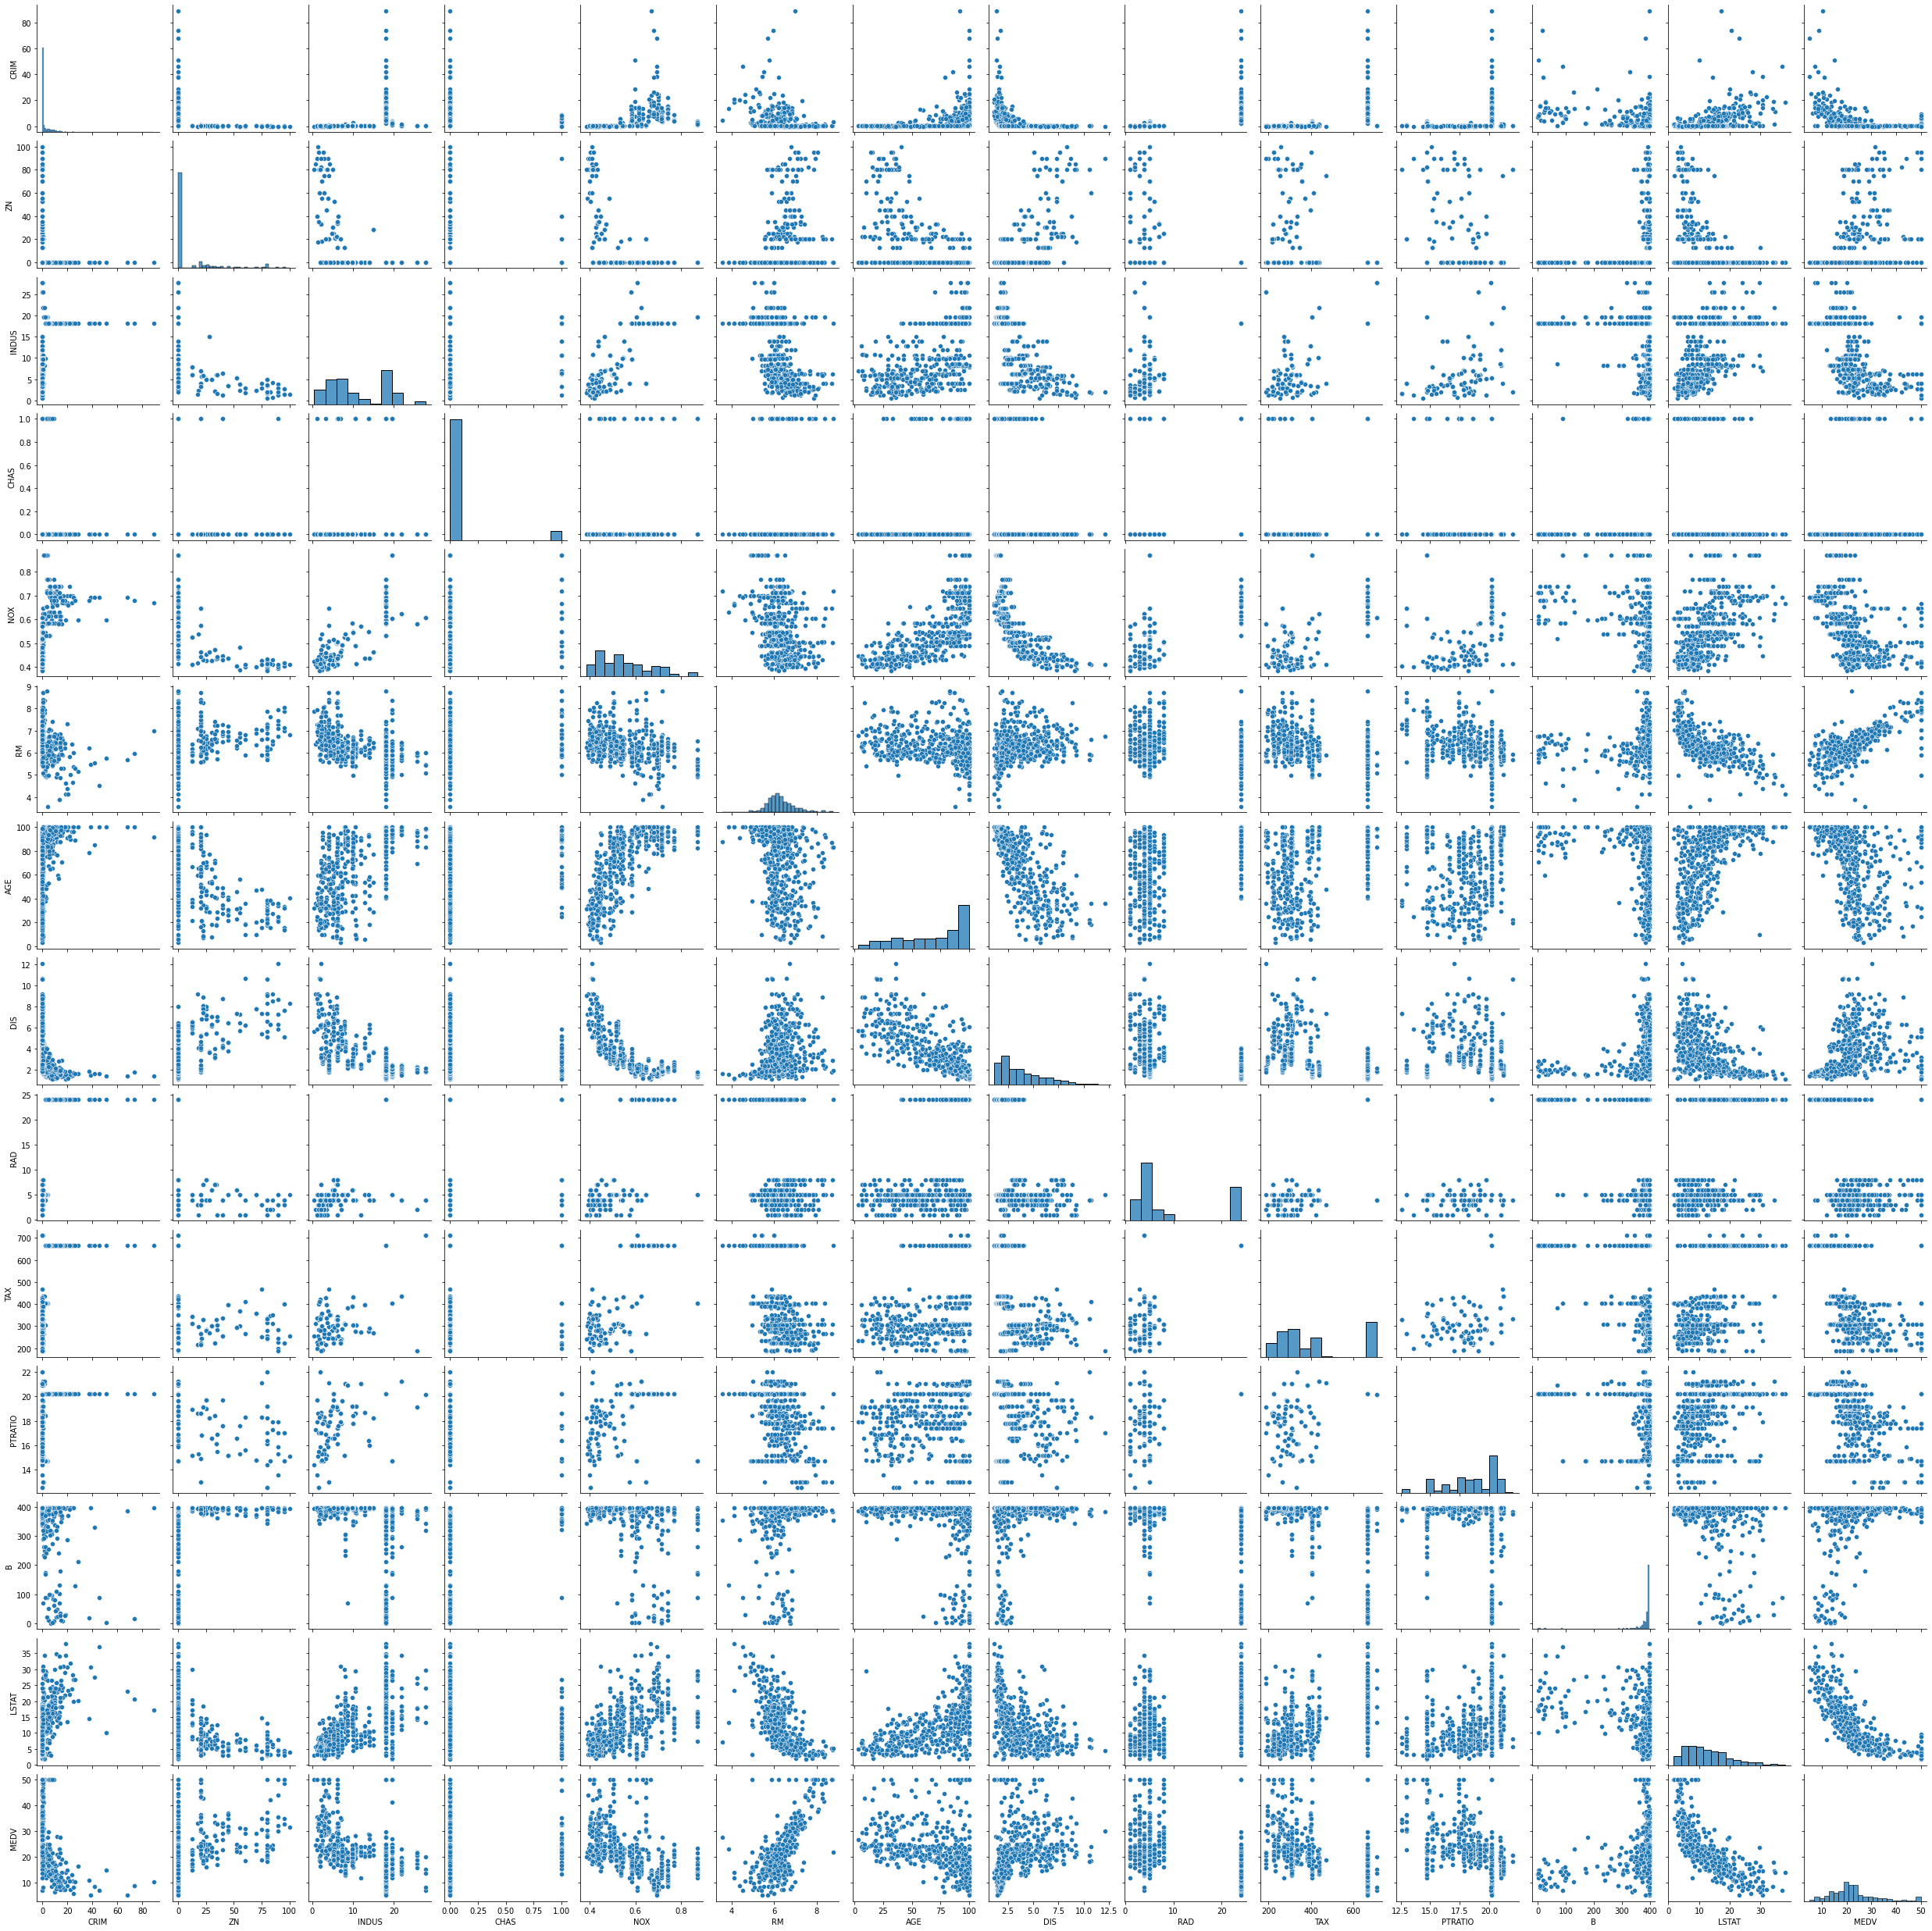

In [48]:
sns.pairplot(df)

<AxesSubplot:xlabel='RM', ylabel='MEDV'>

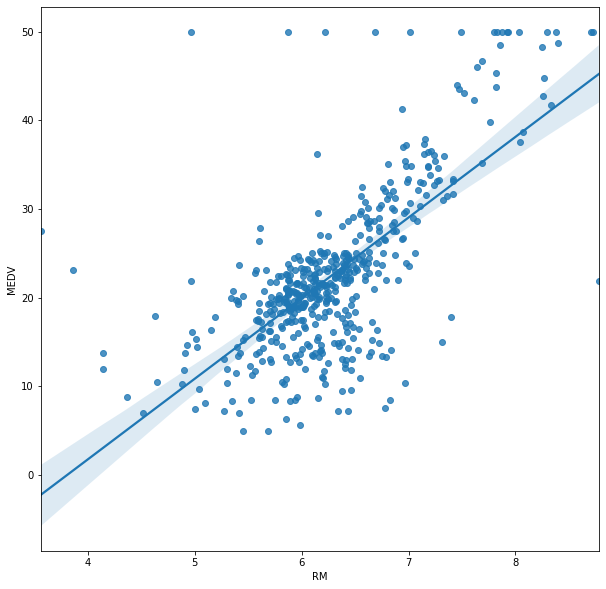

In [59]:
sns.regplot(data=df, x='RM', y='MEDV')

<AxesSubplot:xlabel='LSTAT', ylabel='MEDV'>

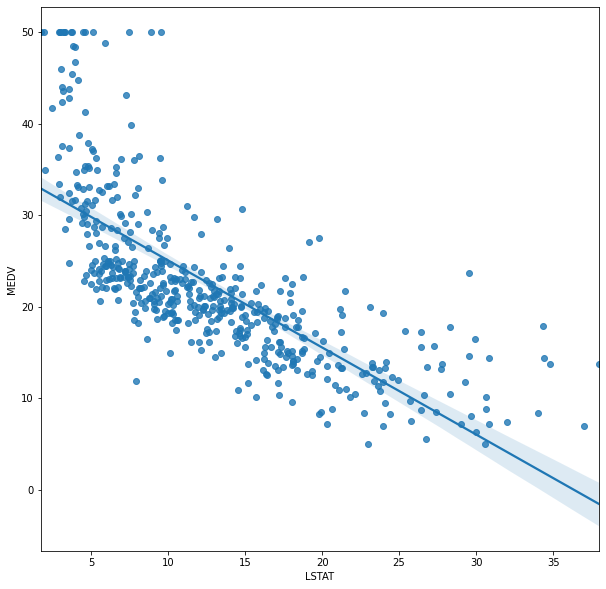

In [60]:
sns.regplot(data=df, x='LSTAT', y='MEDV')

<AxesSubplot:xlabel='DIS', ylabel='MEDV'>

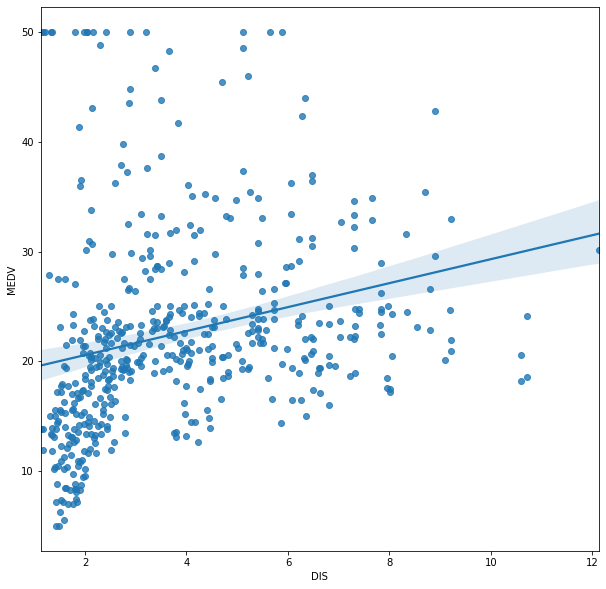

In [61]:
sns.regplot(data=df, x='DIS', y='MEDV')

<AxesSubplot:xlabel='CRIM', ylabel='MEDV'>

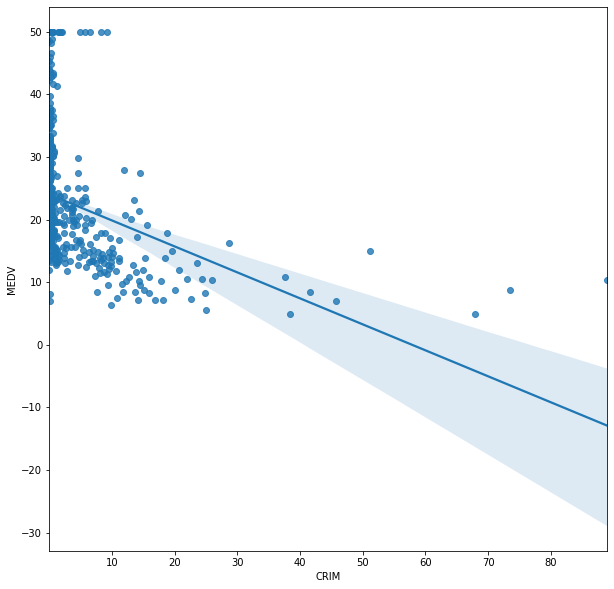

In [62]:
sns.regplot(data=df, x='CRIM', y='MEDV')

<AxesSubplot:xlabel='INDUS', ylabel='MEDV'>

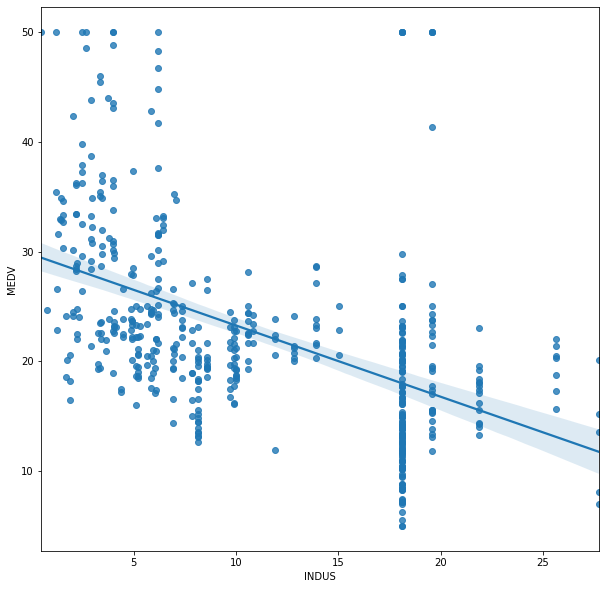

In [63]:
sns.regplot(data=df, x='INDUS', y='MEDV')

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [64]:
# The variables with the strongest correlation are LSTAT and RM, which was expected. 
# I expected CRIM to be stronger, but there are many instances that have a 0 in CRIM and also a low MEDV

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

<AxesSubplot:>

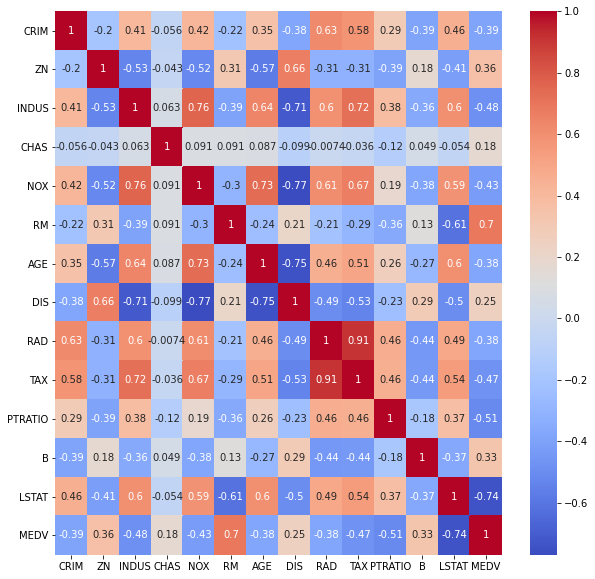

In [65]:
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
# NOX, TAX and PTATIO also have a moderate correlation with MEDV

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [66]:
df.describe()
# the median corresponds to the 50% quantile

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [67]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    return r2_score(y_true, y_predict)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [80]:
train = df.sample(frac=0.8)

In [83]:
test = df.drop(train.index)

In [111]:
X_train, y_train = train[train.columns[:-1]], train[train.columns[-1]]

In [113]:
X_test, y_test = test[test.columns[:-1]], test[test.columns[-1]]

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [108]:
for i in range(2, 11, 2):
    globals()[f"rf{i}"] = RandomForestRegressor(max_depth=i)  

Now, plot the score for each tree on the training set and on the testing set.

In [124]:
scores = [{'max_depth': rf.max_depth,
           'train_score': rf.fit(X_train, y_train).score(X_train, y_train), 
           'test_score': rf.fit(X_train, y_train).score(X_test, y_test)} for rf in [rf2, rf4, rf6, rf8, rf10]]

In [129]:
scores_df = pd.DataFrame(scores)

<AxesSubplot:xlabel='max_depth', ylabel='R2 score'>

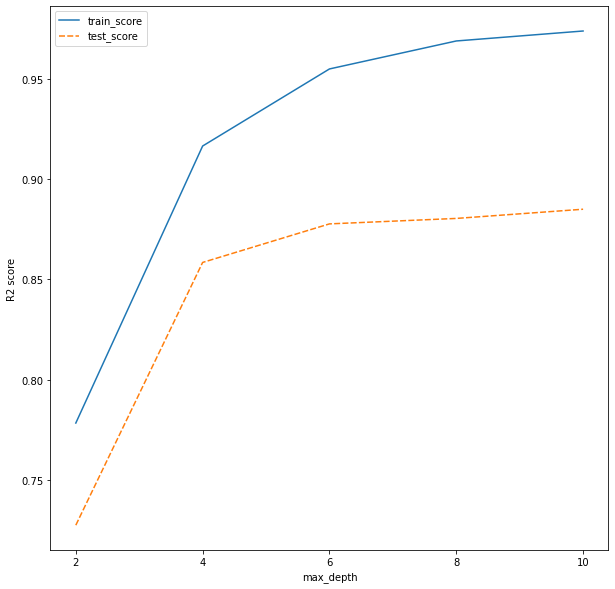

In [145]:
g = sns.lineplot(data=scores_df[['train_score', 'test_score']])
g.set_xticks(range(0,5))
g.set_xticklabels([i for i in range(2,11,2)])
g.set(xlabel = 'max_depth', ylabel = 'R2 score')
g

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [ ]:
# In the case of the train score, there is a steep increase with mode depth.
# In the case of the test score, after 4 the increase is small, and it plateaus after 6.
# this means that after 4 or 6, we start overfitting

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10?

In [ ]:
# As we increase depth bias decreases and variance increases. 
# With a max_depth of 1, we will have high bias and low variance.
# With a max_depth of 10, we will have a low bias and a high variance. 

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [161]:
for rf in [rf2, rf4, rf6, rf8, rf10]:
    print(rf, ':', np.mean(cross_val_score(rf, X, y)))

RandomForestRegressor(max_depth=2) : 0.44620795938693264
RandomForestRegressor(max_depth=4) : 0.5911594224240309
RandomForestRegressor(max_depth=6) : 0.6194672995552576
RandomForestRegressor(max_depth=8) : 0.6152090526355748
RandomForestRegressor(max_depth=10) : 0.6087856378815244


In [162]:
# the optimal model has a max_depth of 6. However, it still needs to be improved, because a 0.61 score is low. 

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [ ]:
# This model is not applicable as it is, since its mean cross validation score is very low. Ww should keep working on it
# to improve it and be able to use it. We would also need to collect new data, since the prices have changed, there may be
# new neighbourhoods and some might be gentrified, so the distribution of the lower income population might have changed. 
# This model wounld no in any case be applicable to a rural city, because their characteristics are radically different. 